# Creating annomaly plots with interannual variability between months for phytoplankton biomass! 

In [2]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

### Size-abundance relationship

In [6]:
ppC_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_ppC.*.nc', recursive=True))
ppC_ds = xr.open_mfdataset(ppC_inds,concat_dim='time', combine='nested')
mp1C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp1C.*.nc', recursive=True))
mp1C_ds = xr.open_mfdataset(mp1C_inds,concat_dim='time', combine='nested')
mp2C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp2C.*.nc', recursive=True))
mp2C_ds = xr.open_mfdataset(mp2C_inds,concat_dim='time', combine='nested')
mp3C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp3C.*.nc', recursive=True))
mp3C_ds = xr.open_mfdataset(mp3C_inds,concat_dim='time', combine='nested')
mp4C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp4C.*.nc', recursive=True))
mp4C_ds = xr.open_mfdataset(mp4C_inds,concat_dim='time', combine='nested')
diazC_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diazC.*.nc', recursive=True))
diazC_ds = xr.open_mfdataset(diazC_inds,concat_dim='time', combine='nested')
diat1C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diat1C.*.nc', recursive=True))
diat1C_ds = xr.open_mfdataset(diat1C_inds,concat_dim='time', combine='nested')
diat2C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diat2C.*.nc', recursive=True))
diat2C_ds = xr.open_mfdataset(diat2C_inds,concat_dim='time', combine='nested')
diat3C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_diat3C.*.nc', recursive=True))
diat3C_ds = xr.open_mfdataset(diat3C_inds,concat_dim='time', combine='nested')

OSError: no files to open

In [6]:
phytoC = np.stack([ppC_ds.ppC, mp1C_ds.mp1C, diazC_ds.diazC, 
                               mp2C_ds.mp2C, diat1C_ds.diat1C, diat2C_ds.diat2C, 
                               mp3C_ds.mp3C, diat3C_ds.diat3C, mp4C_ds.mp4C])

In [7]:
phytoC.shape

(9, 756, 15, 180, 360)

In [8]:
phytoC_ds_inter = np.empty([9,63,12,15,180,360])
phytoC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    phytoC_ds_inter[:,i,:,:,:,:] = phytoC[:,x[i]:x[i]+12,:,:,:]

In [ ]:
phytoC_ds_inter.shape

(9, 63, 12, 15, 180, 360)

### Biomass

In [ ]:
phytoC_bm = np.sum(phytoC_ds_inter, axis=3) * 10/150 #integrate over depth #mmol m-3
phytoC_bm = phytoC_bm * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

In [ ]:
phytoC_bm.shape

(9, 63, 12, 180, 360)

### Separate by Arctic Regions

In [ ]:
phytoC_bm_ao = np.nanmean(phytoC_bm[:,:,:,170:180,:], axis=(3,4))
phytoC_bm_cs = np.nanmean(phytoC_bm[:,:,:,149:170,0:25], axis = (3,4))
phytoC_bm_bs = np.nanmean(phytoC_bm[:,:,:,149:170,25:55], axis = (3,4))
phytoC_bm_ca = np.nanmean(phytoC_bm[:,:,:,149:170,55:110], axis = (3,4))
phytoC_bm_bb = np.nanmean(phytoC_bm[:,:,:,149:170,110:135], axis = (3,4))
phytoC_bm_ess = np.nanmean(phytoC_bm[:,:,:,149:170,325:360], axis = (3,4))
phytoC_bm_ls = np.nanmean(phytoC_bm[:,:,:,149:170,270:325], axis = (3,4))
phytoC_bm_ns = np.nanmean(phytoC_bm[:,:,:,149:170,155:205], axis = (3,4))
phytoC_bm_bts =np.nanmean(phytoC_bm[:,:,:,149:170,205:233], axis = (3,4))
phytoC_bm_ks = np.nanmean(phytoC_bm[:,:,:,149:170,233:270], axis = (3,4))

In [ ]:
phytoC_bm_ao.shape

(9, 63, 12)

## Anomaly is monthly climatology minus the average climatology from the whole time period. 

In [ ]:
phytoC_bm_ao_anom = np.nansum(phytoC_bm_ao,axis=0)-np.nanmean(np.nansum(phytoC_bm_ao,axis=0),axis=0)
phytoC_bm_cs_anom = np.nansum(phytoC_bm_cs,axis=0)-np.nanmean(np.nansum(phytoC_bm_cs,axis=0),axis=0)
phytoC_bm_bs_anom = np.nansum(phytoC_bm_bs,axis=0)-np.nanmean(np.nansum(phytoC_bm_bs,axis=0),axis=0)
phytoC_bm_ca_anom = np.nansum(phytoC_bm_ca,axis=0)-np.nanmean(np.nansum(phytoC_bm_ca,axis=0),axis=0)
phytoC_bm_bb_anom = np.nansum(phytoC_bm_bb,axis=0)-np.nanmean(np.nansum(phytoC_bm_bb,axis=0),axis=0)
phytoC_bm_ess_anom = np.nansum(phytoC_bm_ess,axis=0)-np.nanmean(np.nansum(phytoC_bm_ess,axis=0),axis=0)
phytoC_bm_ls_anom = np.nansum(phytoC_bm_ls,axis=0)-np.nanmean(np.nansum(phytoC_bm_ls,axis=0),axis=0)
phytoC_bm_ns_anom = np.nansum(phytoC_bm_ns,axis=0)-np.nanmean(np.nansum(phytoC_bm_ns,axis=0),axis=0)
phytoC_bm_bts_anom = np.nansum(phytoC_bm_bts,axis=0)-np.nanmean(np.nansum(phytoC_bm_bts,axis=0),axis=0)
phytoC_bm_ks_anom = np.nansum(phytoC_bm_ks,axis=0)-np.nanmean(np.nansum(phytoC_bm_ks,axis=0),axis=0)

In [ ]:
phytoC_bm_ao_anom.shape

(63, 12)

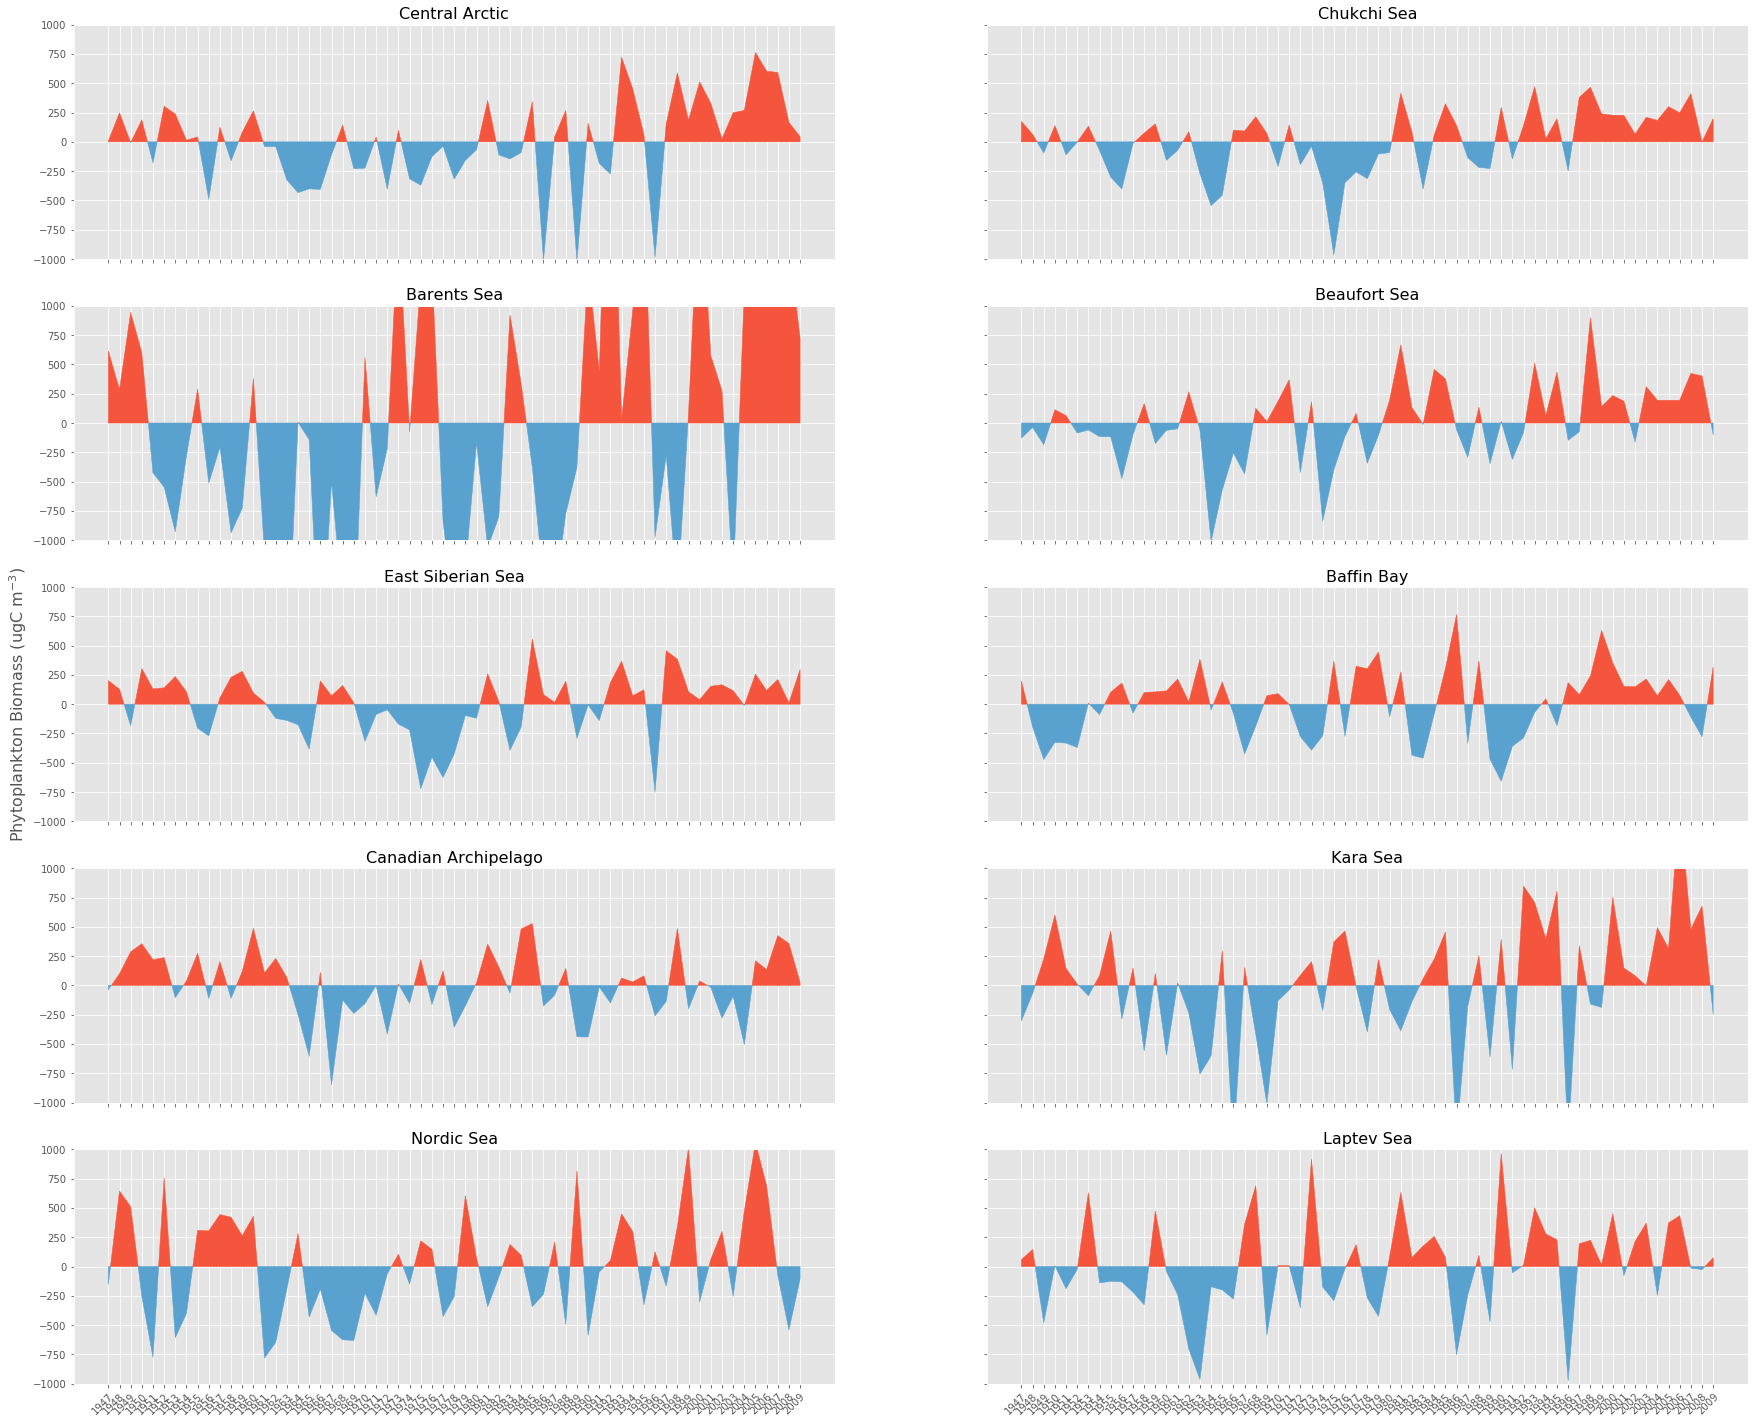

In [ ]:
plt.style.use('ggplot')

years = ['1947', '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(phytoC_bm_ao_anom,axis=1), where=np.nanmean(phytoC_bm_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(phytoC_bm_ao_anom,axis=1), where=np.nanmean(phytoC_bm_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16); 
ax1.set_ylim(-1000,1000);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(phytoC_bm_bts_anom,axis=1), where=np.nanmean(phytoC_bm_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(phytoC_bm_bts_anom,axis=1), where=np.nanmean(phytoC_bm_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16); 
ax2.set_ylim(-1000,1000);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(phytoC_bm_cs_anom,axis=1), where=np.nanmean(phytoC_bm_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(phytoC_bm_cs_anom,axis=1), where=np.nanmean(phytoC_bm_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-1000,1000);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(phytoC_bm_ess_anom,axis=1), where=np.nanmean(phytoC_bm_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(phytoC_bm_ess_anom,axis=1), where=np.nanmean(phytoC_bm_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_ylabel('Phytoplankton Biomass (ugC m$^{-3}$)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); 
ax4.set_ylim(-1000,1000);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(phytoC_bm_ca_anom,axis=1), where=np.nanmean(phytoC_bm_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(phytoC_bm_ca_anom,axis=1), where=np.nanmean(phytoC_bm_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16); 
ax5.set_ylim(-1000,1000);
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
ax6.fill_between(years, np.nanmean(phytoC_bm_ns_anom,axis=1), where=np.nanmean(phytoC_bm_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(phytoC_bm_ns_anom,axis=1), where=np.nanmean(phytoC_bm_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16); 
ax6.set_ylim(-1000,1000);
ax6.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(phytoC_bm_bs_anom,axis=1), where=np.nanmean(phytoC_bm_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(phytoC_bm_bs_anom,axis=1), where=np.nanmean(phytoC_bm_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-1000,1000);

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(phytoC_bm_bb_anom,axis=1), where=np.nanmean(phytoC_bm_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(phytoC_bm_bb_anom,axis=1), where=np.nanmean(phytoC_bm_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-1000,1000);

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(phytoC_bm_ks_anom,axis=1), where=np.nanmean(phytoC_bm_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(phytoC_bm_ks_anom,axis=1), where=np.nanmean(phytoC_bm_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-1000,1000);

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(phytoC_bm_ls_anom,axis=1), where=np.nanmean(phytoC_bm_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(phytoC_bm_ls_anom,axis=1), where=np.nanmean(phytoC_bm_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
                    "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
                    "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
                    "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
                    "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
                    '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_ylim(-1000,1000);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phyto_biomass_anomaly',dpi=600, bbox_inches='tight')

plt.show()